In [1]:
%cd ../

/home/eli/AnacondaProjects/HTFATorch


In [2]:
import logging
import numpy as np
import re

import htfa_torch.dtfa as DTFA
import htfa_torch.niidb as niidb
import htfa_torch.utils as utils

In [3]:
%matplotlib inline

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
lepping_db = niidb.FMriActivationsDb('data/sound_depression.db', mask='/home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz')

In [6]:
dtfa = DTFA.DeepTFA([b for (i, b) in enumerate(lepping_db.all()) if i % 12 == 0], mask='/home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz', num_factors=100, embedding_dim=2)

07/31/2019 18:43:58 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control01/func/sub-control01_task-nonmusic_run-5_bold_space-MNI152NLin2009cAsym_preproc.nii.gz with mask /home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz (zscore=True, smooth=6)
07/31/2019 18:44:00 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control01/func/sub-control01_task-nonmusic_run-4_bold_space-MNI152NLin2009cAsym_preproc.nii.gz with mask /home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz (zscore=True, smooth=6)
07/31/2019 18:44:02 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control02/func/sub-control02_task-music_run-3_bold_space-MNI152NLin2009cAsym_preproc.nii.gz with mask /home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz (zscore=True, smooth=6)
07/31/2019 18:44:04 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control

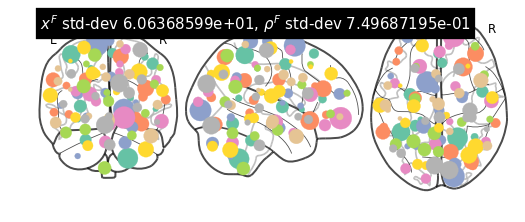

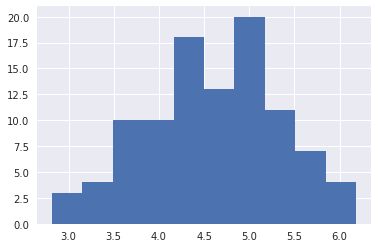

(<nilearn.plotting.displays.OrthoProjector at 0x7f0f21412828>,
 tensor([[-3.1555e+01, -8.5307e+01, -1.0786e+01],
         [ 4.9815e+01,  1.4494e+01,  7.1622e-01],
         [-6.5650e-01,  3.6227e+01,  1.1588e+01],
         [-1.8456e+01, -3.2494e+01,  4.3801e+01],
         [ 2.0509e+01, -5.1689e+01, -5.1230e+01],
         [ 3.8374e+01, -5.0781e+01,  5.5496e+01],
         [-2.3879e+01, -3.9014e+01, -3.1921e+01],
         [ 4.2678e+00,  2.7152e+01,  5.9487e+01],
         [-2.9470e+01, -6.0754e+00,  3.5194e+00],
         [ 2.3153e+01, -5.1917e+01,  1.2550e+01],
         [ 2.0559e+01, -5.8381e+01, -1.4013e+01],
         [ 4.6574e+01, -3.0807e+00,  4.8246e+01],
         [-3.9029e+01, -4.5560e+01,  5.8088e+01],
         [ 1.3098e+01, -6.6637e+01,  5.5745e+01],
         [-2.3995e+01, -9.6999e+00,  3.1959e+01],
         [-4.1422e+01,  4.0015e+01, -4.9321e+00],
         [ 2.1831e+01,  5.7990e+01,  1.6535e+01],
         [ 3.6509e+01, -8.0804e+01,  1.3435e+01],
         [ 3.9370e+01,  3.6980e+01,  

In [7]:
dtfa.visualize_factor_embedding()

In [8]:
losses = dtfa.train(num_steps=1000, learning_rate={'q': 1e-3, 'p': 1e-4}, log_level=logging.INFO, num_particles=4,
                    batch_size=3, use_cuda=True, checkpoint_steps=100, blocks_batch_size=2, patience=100)

07/31/2019 18:47:53 [Epoch 1] (25805ms) Posterior free-energy 2.94627800e+07 = KL from prior 5.26373281e+04 - log-likelihood -3.04237040e+07
07/31/2019 18:47:53 Saving checkpoint...
07/31/2019 18:48:19 [Epoch 2] (26134ms) Posterior free-energy 2.92595980e+07 = KL from prior 3.32567188e+04 - log-likelihood -3.02103280e+07
07/31/2019 18:48:45 [Epoch 3] (25563ms) Posterior free-energy 2.90544360e+07 = KL from prior 3.10517461e+04 - log-likelihood -2.99779720e+07
07/31/2019 18:49:11 [Epoch 4] (25634ms) Posterior free-energy 2.88855200e+07 = KL from prior 2.90180547e+04 - log-likelihood -2.97869920e+07
07/31/2019 18:49:36 [Epoch 5] (25166ms) Posterior free-energy 2.87397380e+07 = KL from prior 2.70282305e+04 - log-likelihood -2.95510240e+07
07/31/2019 18:50:01 [Epoch 6] (25164ms) Posterior free-energy 2.85189960e+07 = KL from prior 2.48727480e+04 - log-likelihood -2.93035720e+07
07/31/2019 18:50:26 [Epoch 7] (25159ms) Posterior free-energy 2.83200880e+07 = KL from prior 2.28048945e+04 - log

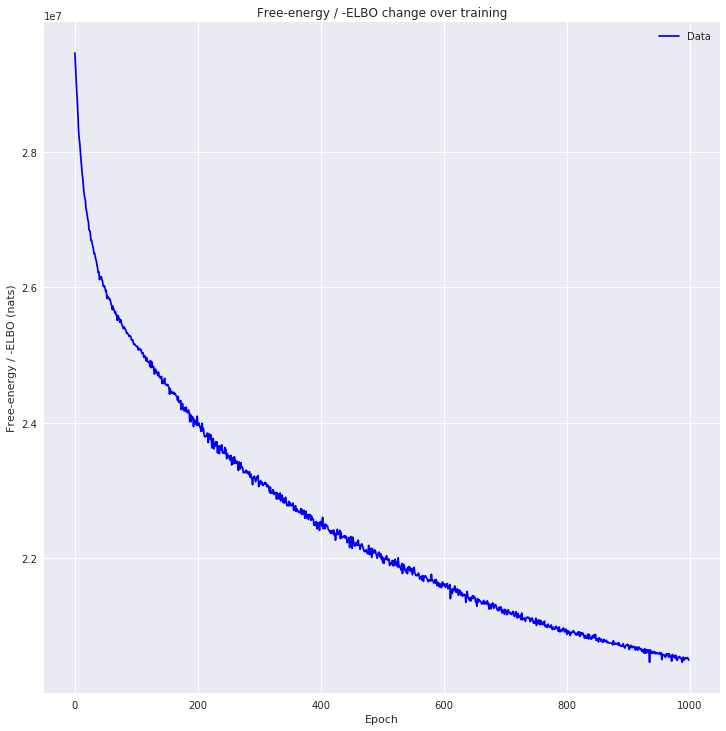

In [9]:
utils.plot_losses(losses)

In [10]:
def subject_labeler(subject):
    subject_regex = re.compile("([A-Za-z]+)([0-9]{1,2})")
    m = subject_regex.search(subject)
    condition, sub_num = m.groups()
    if condition == 'mdd':
        condition = 'Major Depressive'
    elif condition == 'control':
        condition = 'Control'
    return '%s Participant %d' % (condition, int(sub_num))

In [11]:
def task_labeler(task):
    if task == 'negative_music':
        task = 'Negative music'
    elif task == 'positive_music':
        task = 'Positive music'
    else:
        task = task.capitalize()
    return task

In [14]:
def lepping_2017_labeler(block):
    subject = subject_labeler(block.subject)
    task = task_labeler(block.task)
    return subject + ', ' + task + ' stimulus'

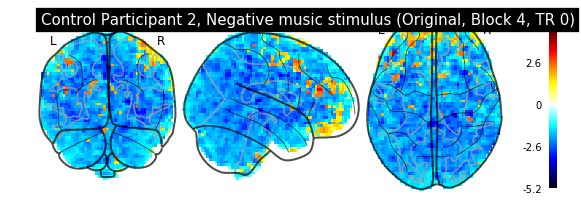

08/01/2019 10:21:15 Reconstruction Error (Frobenius Norm): 6.52858215e+02 out of 8.63967224e+02


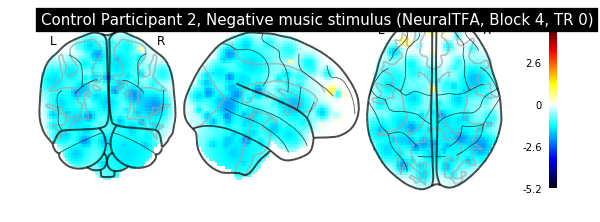

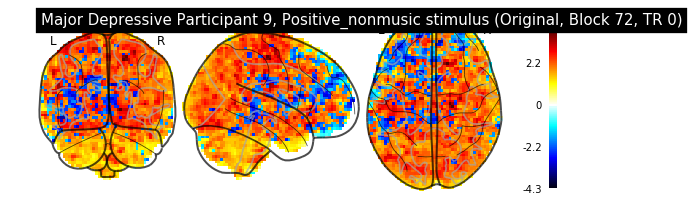

08/01/2019 10:21:18 Reconstruction Error (Frobenius Norm): 7.39162048e+02 out of 9.09648376e+02


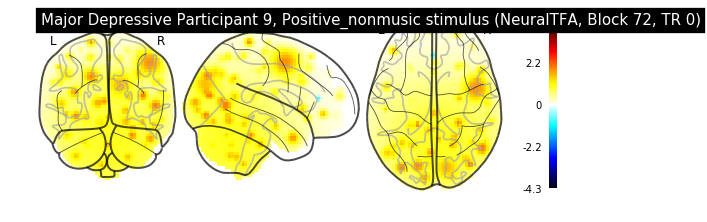

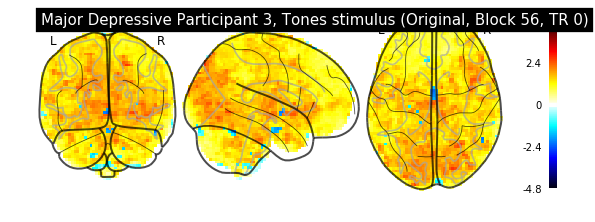

08/01/2019 10:21:21 Reconstruction Error (Frobenius Norm): 4.65942993e+02 out of 6.99515137e+02


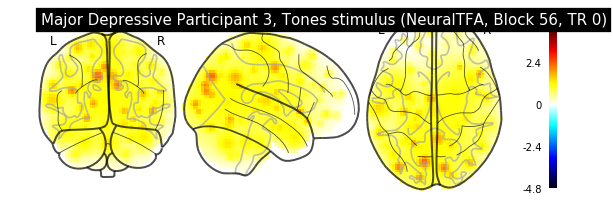

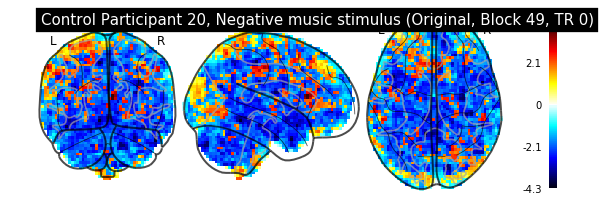

08/01/2019 10:21:24 Reconstruction Error (Frobenius Norm): 7.73654907e+02 out of 8.07835510e+02


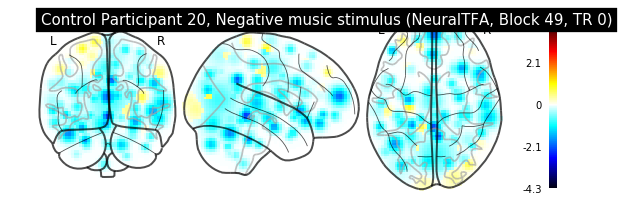

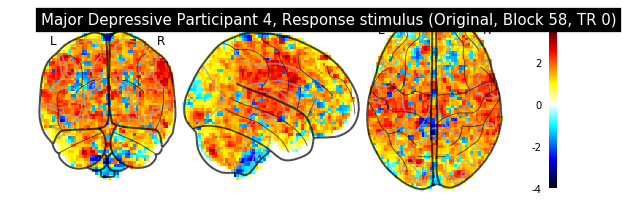

08/01/2019 10:21:26 Reconstruction Error (Frobenius Norm): 2.04766495e+02 out of 2.20287140e+02


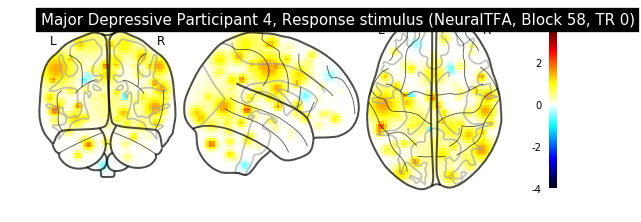

In [15]:
for b in np.random.choice(range(dtfa.num_blocks), 5):
    dtfa.plot_original_brain(b, labeler=lepping_2017_labeler)
    dtfa.plot_reconstruction(b, labeler=lepping_2017_labeler)

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


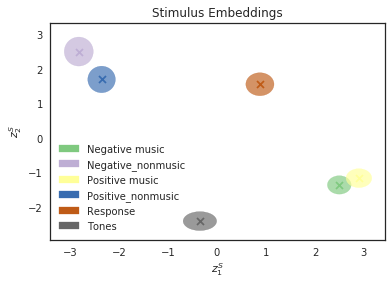

In [16]:
dtfa.scatter_task_embedding(labeler=task_labeler, figsize=None)

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


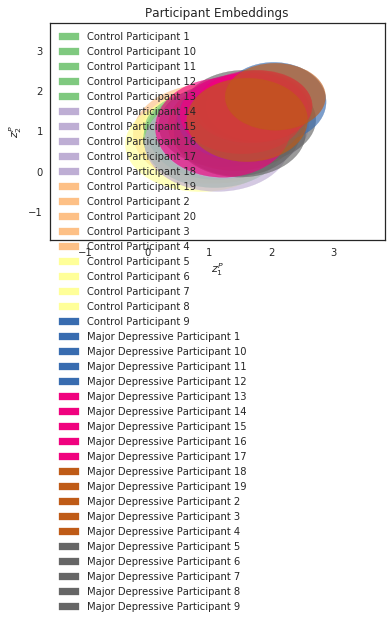

In [17]:
dtfa.scatter_subject_embedding(labeler=subject_labeler, figsize=None)

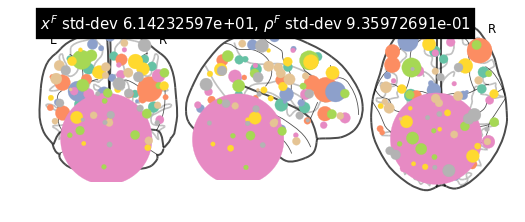

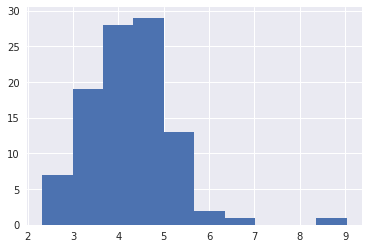

(<nilearn.plotting.displays.OrthoProjector at 0x7f0ecf6ffa58>,
 tensor([[-33.8243, -83.8631,  -7.2208],
         [ 47.6625,  17.2941,   2.5973],
         [ -3.3418,  39.1626,  14.1967],
         [-20.8341, -33.7878,  43.0519],
         [ 19.7571, -54.1309, -49.8923],
         [ 38.0794, -51.4651,  52.9022],
         [-24.1034, -43.8732, -33.5520],
         [  5.7869,  31.0907,  56.2706],
         [-28.9515,  -7.1314,   5.4841],
         [ 27.9599, -51.9516,  16.5324],
         [ 17.9394, -61.9257, -14.0220],
         [ 45.9299,  -0.2704,  45.3751],
         [-40.5597, -45.1214,  53.5794],
         [ 13.8673, -69.1607,  52.5221],
         [-22.9676,  -7.5216,  31.6870],
         [-47.9211,  38.7389,  -3.7409],
         [ 21.9855,  56.5881,  16.3199],
         [ 36.0374, -80.5502,  10.7230],
         [ 43.5640,  40.0059,  21.3942],
         [-61.0079, -42.1552,   2.0769],
         [ 30.1255,  20.2586, -11.2564],
         [-48.2085,  25.0721,  28.2706],
         [ 38.0118, -79.2722, -11.2

In [18]:
dtfa.visualize_factor_embedding()

In [22]:
dtfa.average_reconstruction_error(weighted=False)

08/01/2019 10:21:54 Average reconstruction error (MSE): 5.33654282e+02 +/- 2.00459351e+02
08/01/2019 10:21:54 Average data norm (Euclidean): 6.83583280e+02 +/- 2.97599822e+02
08/01/2019 10:21:54 Percent average reconstruction error: 81.334519 +/- 1.34468867e+01


(array([658.21191406, 592.90783691, 572.69842529, 608.09924316,
        652.85821533, 743.86737061, 563.62634277, 554.25933838,
        551.60021973, 589.30065918, 669.40026855, 596.08740234,
        637.42474365, 490.43484497, 623.10595703, 610.54522705,
        613.64080811, 568.09881592, 480.90185547, 584.17993164,
        602.1697998 , 555.19085693, 487.29660034, 614.35717773,
        631.59796143, 733.91894531, 660.60699463, 633.35467529,
        535.92633057, 581.21594238, 714.72796631, 582.58880615,
        507.22543335, 501.36050415, 567.98791504, 840.6605835 ,
        789.92663574, 768.85693359, 520.46099854, 511.11431885,
        813.09173584, 720.81762695, 695.04455566, 715.21746826,
        832.61798096, 866.93603516, 802.34136963, 797.66064453,
        742.63446045, 773.65490723, 608.12384033, 546.7175293 ,
        532.21325684, 536.17785645, 555.79968262, 459.64242554,
        465.94299316, 661.71990967, 204.76649475, 629.92987061,
        247.08543396, 201.33221436, 630.

In [20]:
def condition_labeler(subject):
    subject_regex = re.compile("([A-Za-z]+)([0-9]{1,2})")
    m = subject_regex.search(subject)
    condition, sub_num = m.groups()
    if condition == 'mdd':
        return 'Major Depressive'
    elif condition == 'control':
        return 'Control'
    return condition

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


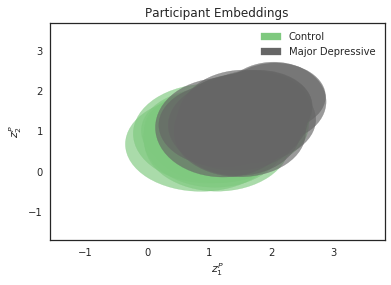

In [21]:
dtfa.scatter_subject_embedding(labeler=condition_labeler, figsize=None)